In [26]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict

import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import theano.tensor as tt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [4]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [5]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [6]:
groups = generate_groups_data(prison_pivot, groups_input, seasonality=4, h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [184]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

In [283]:
ind_forecast = []
for i in range(groups['train']['s']):    
    with pm.Model() as model:

        period = pm.Laplace('period', 4, 0.1)


        l_t = pm.Gamma('l_t', alpha=5, beta=1)
        l_p = pm.Gamma('l_p', alpha=2, beta=1)
        η_trend = pm.Gamma('η_trend', 2, 1)
        η_per = pm.Gamma('η_per',2, 1)
        σ  = pm.HalfNormal("σ",  sigma=0.15)

        a = pm.Normal('a', mu=0, sd=10) 
        b = pm.Laplace('b', mu=0, b=0.05)

        mu_func = pm.gp.mean.Linear(intercept = a,
                                   coeffs = b)

        # cov function for the GP 
        cov = (η_trend**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t)
                + η_per**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                + pm.gp.cov.WhiteNoise(σ))

        gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f = gp.prior('f', X=X, reparameterize=True)

        y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])
        mp = pm.find_MAP(maxeval=5000, progressbar = False)

        f_n0 = gp.conditional('f_n0', Xnew=X_new)

        y_pred_new0 = pm.Poisson("y_pred_new0", 
                                mu=tt.exp(f_n0), 
                                shape=X_new.shape[0])

        pred_samples0 = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new0], 
                                                  samples=200,
                                                  progressbar = False)

    print(str(i)+'/'+str(groups['train']['s']))
    ind_forecast.append(np.mean(pred_samples0['y_pred_new0'][:,groups['train']['n']:groups['predict']['n']], axis=0))

0/32
1/32
2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32


# Test a single series

In [280]:
series = 31

with pm.Model() as model:

    period = pm.Laplace('period', 4, 0.1)


    l_t = pm.Gamma('l_t', alpha=5, beta=1)
    l_p = pm.Gamma('l_p', alpha=2, beta=1)
    η_trend = pm.Gamma('η_trend', 2,1)
    η_per = pm.Gamma('η_per',2, 1)
    σ  = pm.HalfNormal("σ",  sigma=0.15)

    a = pm.Normal('a', mu=0, sd=10) 
    b = pm.Laplace('b', mu=0, b=0.05)

    mu_func = pm.gp.mean.Linear(intercept = a,
                               coeffs = b)

    # cov function for the GP 
    cov = (η_trend**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t)
            + η_per**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
            + pm.gp.cov.WhiteNoise(σ))

    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
    f = gp.prior('f', X=X, reparameterize=True)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])
    mp = pm.find_MAP(maxeval=5000)

In [281]:
with pm.Model() as model:
    f_n0 = gp.conditional('f_n0', Xnew=X_new)

    y_pred_new0 = pm.Poisson("y_pred_new0", 
                            mu=tt.exp(f_n0), 
                            shape=X_new.shape[0])

    pred_samples0 = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new0], 
                                              samples=200,
                                              progressbar = False)

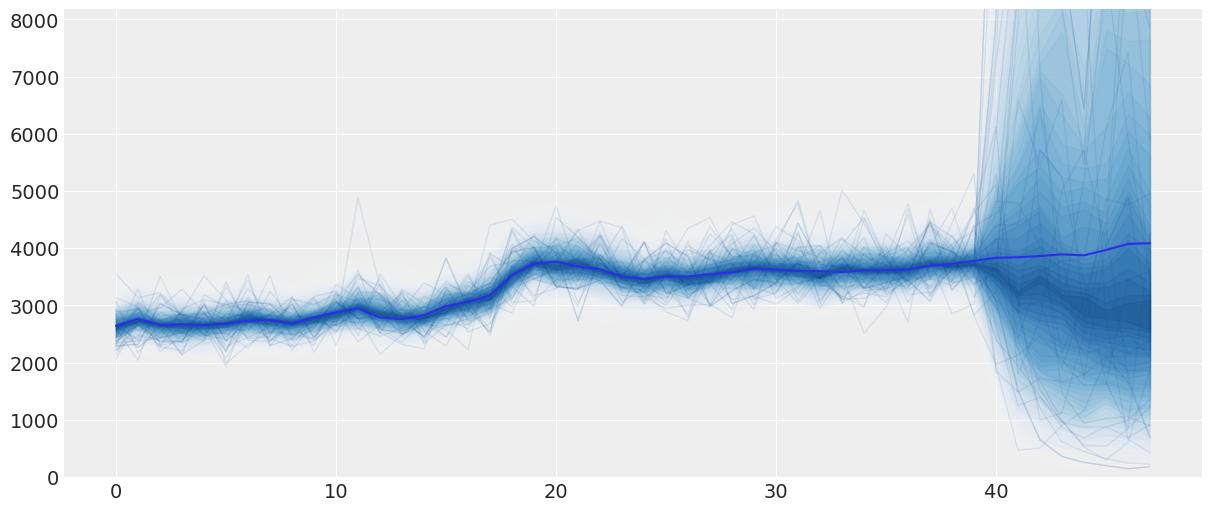

In [282]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples0['y_pred_new0'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.arange(groups['predict']['n']),groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series])
plt.ylim(0,max(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series])*2);